In [69]:
import numpy as np
from tqdm.auto import tqdm, trange
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from IPython.display import clear_output
import tarfile
import pickle
import os

import torch
import torchvision

from torch import nn, optim
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.models as models

In [13]:
# config file

path = "F:/Проекты/SBER CV/imagewoof2.tgz"
path_unzip = 'F:/Проекты/SBER CV'
path_work = 'F:/Проекты/SBER CV/imagewoof2'
shape_resize = (224, 224)
batch_size = 256
torch.manual_seed(17)
def_n_ep = 3
dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
cr = nn.CrossEntropyLoss()

In [3]:
# Зададим словарь классов
dog_breeds = {'n02086240' : 'австралийский терьер',
              'n02087394' : 'бордер-терьер',
              'n02088364' : 'самоед',
              'n02089973' : 'бигль',
              'n02093754' : 'ши-тцу',
              'n02096294' : 'английский фоксхаунд',
              'n02099601' : 'родезийский риджбек',
              'n02105641' : 'динго',
              'n02111889' : 'золотистый ретривер',
              'n02115641' : 'староанглийская овчарка'}

In [28]:
# results file
normalize_dict = {'train' : {'mean' : [], 'std' : []},
                 'val' : {'mean' : [], 'std' : []}}

history_dict = {}

results = {}

In [27]:
results

{1: [2, 0.875]}

In [154]:
# Функция для разархивирования датасета
def dataset_load(path, path_unzip):
    '''INPUT 
            -> path: path to dataset archive
            -> path_work: path to work dir for unzip
            
        OUTPUT 
            -> unzip dataset to work dir'''
    with tarfile.open(path, "r") as tar:
        tar.extractall(path_unzip)
    return

In [ ]:
# Pipeline 1 *unzip*
dataset_load(path, path_unzip)

In [16]:
df = pd.read_csv(f'{path_work}/noisy_imagewoof.csv')

In [35]:
Train = df[df.is_valid == False]
Test = df[df.is_valid == True]

In [40]:
Train.noisy_labels_0.value_counts() / Train.shape[0]

n02099601    0.105152
n02093754    0.105152
n02096294    0.104488
n02087394    0.104377
n02086240    0.104266
n02115641    0.104155
n02088364    0.103269
n02105641    0.102825
n02111889    0.102050
n02089973    0.064266
Name: noisy_labels_0, dtype: float64

In [41]:
Test.noisy_labels_0.value_counts() / Test.shape[0]

n02111889    0.109188
n02105641    0.107406
n02088364    0.106388
n02115641    0.104352
n02086240    0.104098
n02087394    0.103843
n02096294    0.103589
n02099601    0.102062
n02093754    0.102062
n02089973    0.057012
Name: noisy_labels_0, dtype: float64

In [45]:
Train[Train.noisy_labels_0 == 'n02111889'].noisy_labels_0.value_counts()

n02111889    921
Name: noisy_labels_0, dtype: int64

In [46]:
Train[Train.noisy_labels_0 == 'n02105641'].noisy_labels_0.value_counts()

n02105641    928
Name: noisy_labels_0, dtype: int64

In [47]:
Train[Train.noisy_labels_0 == 'n02088364'].noisy_labels_0.value_counts()

n02088364    932
Name: noisy_labels_0, dtype: int64

In [48]:
Train[Train.noisy_labels_0 == 'n02115641'].noisy_labels_0.value_counts()

n02115641    940
Name: noisy_labels_0, dtype: int64

In [49]:
Train[Train.noisy_labels_0 == 'n02086240'].noisy_labels_0.value_counts()

n02086240    941
Name: noisy_labels_0, dtype: int64

In [50]:
Train[Train.noisy_labels_0 == 'n02087394'].noisy_labels_0.value_counts()

n02087394    942
Name: noisy_labels_0, dtype: int64

In [51]:
Train[Train.noisy_labels_0 == 'n02096294'].noisy_labels_0.value_counts()

n02096294    943
Name: noisy_labels_0, dtype: int64

In [52]:
Train[Train.noisy_labels_0 == 'n02099601'].noisy_labels_0.value_counts()

n02099601    949
Name: noisy_labels_0, dtype: int64

In [53]:
Train[Train.noisy_labels_0 == 'n02093754'].noisy_labels_0.value_counts()

n02093754    949
Name: noisy_labels_0, dtype: int64

In [54]:
Train[Train.noisy_labels_0 == 'n02089973'].noisy_labels_0.value_counts()

n02089973    580
Name: noisy_labels_0, dtype: int64

In [56]:
# Соотношение между выборками
Train.shape[0] / Test.shape[0]

2.2970221430389413

**Вывод:** меньше всего изображений породы "Бигль" - 6 %. В тоже время других классов поровну примерно по 10%

# Напишем функцию подготовки данных

In [175]:
# преобразуем датасет в тензоры
train_transform = T.Compose([T.Resize(shape_resize), T.ToTensor()])
train_dataset = ImageFolder(
    f'{path_work}/train',
    transform=train_transform)

val_dataset = ImageFolder(
    f'{path_work}/val',
    transform=train_transform)

In [176]:
# приравниваем размер batch к размеру выборки
train_dataloader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle=False, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=False, num_workers = 0)

In [177]:
# функция для подсчета среднего и стандартного отклонения в выборке
def mean_std(loader):
    '''INPUT -> dataloader
      OUTPUT - > mean, standard deviation'''
    # shape of images = [b,c,w,h]
    images, lebels = next(iter(loader))

    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean.tolist(), std.tolist()

In [178]:
# Pipeline 2 *mean, std train*
normalize_dict['train']['mean'], normalize_dict['train']['std'] = mean_std(train_dataloader)
print("train mean and std: \n", normalize_dict['train']['mean'], normalize_dict['train']['std'])

train mean and std: 
 [0.48614445328712463, 0.45597901940345764, 0.39378130435943604] [0.2562965154647827, 0.2487899661064148, 0.2581080198287964]


In [179]:
# Pipeline 2 *mean, std val*
normalize_dict['val']['mean'], normalize_dict['val']['std'] = mean_std(val_dataloader)
print("validation mean and std: \n", normalize_dict['val']['mean'], normalize_dict['val']['std'])

validation mean and std: 
 [0.4903455376625061, 0.45952337980270386, 0.3980141282081604] [0.2537788450717926, 0.24654510617256165, 0.2555353343486786]


In [180]:
# Сохраним словарик
with open(f'{path_unzip}/normalize_dict.pickle', 'wb') as f:
    pickle.dump(normalize_dict, f)

In [188]:
normalize_dict

{'train': {'mean': [0.48614445328712463,
   0.45597901940345764,
   0.39378130435943604],
  'std': [0.2562965154647827, 0.2487899661064148, 0.2581080198287964]},
 'val': {'mean': [0.4903455376625061, 0.45952337980270386, 0.3980141282081604],
  'std': [0.2537788450717926, 0.24654510617256165, 0.2555353343486786]}}

# Подготовка данных

In [6]:
# Загружаем параметры нормализации
with open(f'{path_unzip}/normalize_dict.pickle', 'rb') as f:
    normalize_dict = pickle.load(f)
normalize_dict

{'train': {'mean': [0.48614445328712463,
   0.45597901940345764,
   0.39378130435943604],
  'std': [0.2562965154647827, 0.2487899661064148, 0.2581080198287964]},
 'val': {'mean': [0.4903455376625061, 0.45952337980270386, 0.3980141282081604],
  'std': [0.2537788450717926, 0.24654510617256165, 0.2555353343486786]}}

In [7]:
# config file
train_transform = T.Compose([
                        T.Resize(shape_resize),
                        #T.RandomHorizontalFlip(p=0.5),
                        T.ToTensor(),
                        T.Normalize(
                            mean=normalize_dict['train']['mean'],
                            std=normalize_dict['train']['std'])])

val_transform = T.Compose([
                        T.Resize(shape_resize),
                        T.ToTensor(),
                        T.Normalize(
                            mean=normalize_dict['val']['mean'],
                            std=normalize_dict['val']['std'])])


In [8]:
def get_dataloader(train_transform, val_transform, path_work, batch_size):
    '''INPUT
            -> train_transform: params transformation train data
            -> val_transform: params transformation val data
        OUTPUT
            -> train_dataloader, val_dataloader'''
    
    train_dataset = ImageFolder(
        f'{path_work}/train',
        transform=train_transform)

    val_dataset = ImageFolder(
        f'{path_work}/val',
        transform=val_transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
    return train_dataloader, val_dataloader

In [9]:
# Pipeline 3 *get dataloaders*
train_dataloader, val_dataloader = get_dataloader(train_transform, val_transform, path_work, batch_size)

In [192]:
train_dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 9025
    Root location: F:/Проекты/SBER CV/imagewoof2/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.48614445328712463, 0.45597901940345764, 0.39378130435943604], std=[0.2562965154647827, 0.2487899661064148, 0.2581080198287964])
           )

# Напишем функцию для логирования результатов

In [10]:
def log_history(num_epoch, train_loss_log, val_loss_log, train_acc_log, val_acc_log, TrLs, TrAc, VaLs, VaAc):
    '''INPUT
            -> history_dict: словарь для записи логов
            -> num_epoch: номер эпохи
            -> train_history: история ибучения batch train
            -> val_history: история ибучения batch val
            -> TrLs: Train loss
            -> TrAc: Train accuracy
            -> VaLs: Val loss
            -> VaAc: Val accuracy
        OUTPUT
            -> dict with model scores and results'''
    
    history_dict[num_epoch] = {'train_loss_log' : train_loss_log,
                                'val_loss_log' : val_loss_log,
                                'train_acc_log' : train_acc_log,
                                'val_acc_log' : val_acc_log,
                                'TrLs' : TrLs,
                                'TrAc' : TrAc,
                                'VaLs' : VaLs,
                                'VaAc' : VaAc}
    return

In [11]:
def plot_history(train_history, val_history, title="loss"):
    '''INPUT
            -> train_history : история ибучения batch train
            -> val_history : история ибучения batch val
            -> title = "loss"
        OUTPUT
            -> plot results'''
    
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [22]:
def train(model, optimizer, train_dataloader, val_dataloader, criterion=cr, n_epochs=def_n_ep, device=dev):
    '''INPUT
            -> model: model
            -> criterion: nn.CrossEntropyLoss
            -> optimizer: optim.SGD(model.parameters(), momentum=0.95, lr=0.1)
            -> train_dataloader
            -> val_dataloader
            -> n_epochs: number of epochs
            -> history_dict: empty dict
            -> device: torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
            -> scheduler: torch.optim.lr_scheduler.CosineAnnealingLR
        OUTPUT
            -> trainded model
    '''
    best_score = [0, 0] # [num_epoch, best_score]
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []  
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.0001, last_epoch=-1, verbose=False)
    
    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels_ in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels_.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss.cpu(), loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.data.cpu() / labels_.size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred, dim=-1).cpu()
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes.cpu() == labels_).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels_).sum() / labels_.shape[0])
        
        
        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels_ in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels_.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss.cpu(), loss.cpu().unsqueeze(0) / labels.cpu().size(0)))

                pred_classes = torch.argmax(y_pred, dim=-1).cpu()
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels_).sum().unsqueeze(0)
                ))
        
        
        val_loss_log.append(val_epoch_loss.cpu().mean())
        val_acc_log.append(val_epoch_true_hits.cpu().sum() / val_epoch_true_hits.cpu().size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")
        
        
        TrLs = train_epoch_loss.mean().item()
        TrAc = (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        VaLs = val_epoch_loss.mean().item()
        VaAc = (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        
        log_history(epoch, train_loss_log, val_loss_log, train_acc_log, val_acc_log, TrLs, TrAc, VaLs, VaAc)
        
        print("Train loss:", TrLs)
        print("Train acc:", TrAc)
        print("Val loss:", VaLs)
        print("Val acc:", VaAc)
        
        # будем сохранять лучший результат
        if VaAc >= best_score[1]:
            best_score[0], best_score[1] = epoch, VaAc
    
    return best_score

# Обучение

In [159]:
# Pipeline 4
num_experiment = 1

In [139]:
# Pipeline 4
os.mkdir(f'{path_unzip}/{num_experiment}')

In [193]:
# models file
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=10)

In [194]:
model = model.to(dev)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.1)

In [195]:
train(model, optimizer, train_dataloader, val_dataloader, criterion=cr, n_epochs=def_n_ep, device=dev)

Training, epoch 0:   0%|          | 0/36 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [145]:
# Сохраним словарик результатов
with open(f'{path_unzip}/{num_experiment}/history_dict_{num_experiment}.pickle', 'wb') as f:
    pickle.dump(history_dict, f)

# Сохранение модели

In [146]:
torch.save(model, f'{path_unzip}/{num_experiment}/model_{num_experiment}.pt')

# Сохранение резкльтатов экспериментов

In [143]:
# запишем результаты эксперимента
results[num_experiment] = best_score

In [147]:
with open(f'{path_unzip}/results.pickle', 'wb') as f:
    pickle.dump(results, f)

# Напишем функцию для выбора модели

In [24]:
# models file

def chose_model(variant=None):
    '''INPUT
            -> variant: "1"-resnet18, "2"-densenet161, "3"-MobileNetV2'
        OUTPUT
            -> model with changed fc layer
        '''
    if variant is None:
        print('You need chose a variants: "1"-resnet18, "2"-densenet161, "3"-MobileNetV2')
        return
    
    if variant == '1':
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(in_features=512, out_features=10)
        return model

    elif variant == '2':
        model = models.densenet161(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(in_features=2208, out_features=10, bias=True)
        return model

    elif variant == '3':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(in_features=1280, out_features=10, bias=True)
        return model
    
    elif variant == '4':
        model = models.densenet201(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = nn.Linear(in_features=1920, out_features=10, bias=True)
        return model
    
    else:
        return

# Итого

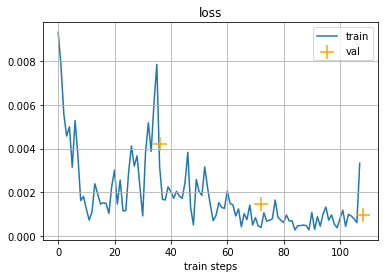

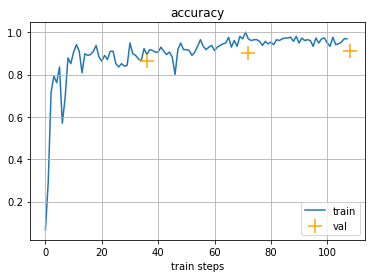

Train loss: 0.0007998337969183922
Train acc: 0.9395616054534912
Val loss: 0.0009552094270475209
Val acc: 0.91015625


In [29]:
# Запуск экспериментов
for num_experiment in range(1, 5): # всего 4 эксперимента
    # Pipeline 4
    os.mkdir(f'{path_unzip}/{num_experiment}')
    model = chose_model(f'{num_experiment}')
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
    best_score = train(model, optimizer, train_dataloader, val_dataloader, criterion=cr, n_epochs=def_n_ep, device=dev)
    # Сохраним словарик результатов
    with open(f'{path_unzip}/{num_experiment}/history_dict_{num_experiment}.pickle', 'wb') as f:
        pickle.dump(history_dict, f)
    # Сохраним модель
    torch.save(model, f'{path_unzip}/{num_experiment}/model_{num_experiment}.pt')
    # запишем результаты эксперимента
    results[num_experiment] = best_score

In [30]:
with open(f'{path_unzip}/results.pickle', 'wb') as f:
    pickle.dump(results, f)

In [31]:
results

{1: [2, 0.87451171875],
 2: [2, 0.912841796875],
 3: [2, 0.880126953125],
 4: [2, 0.91015625]}

# Построим историю обучения лучшей модели

In [32]:
with open(f'{path_unzip}/2/history_dict_2.pickle', 'rb') as f:
    best_hist = pickle.load(f)

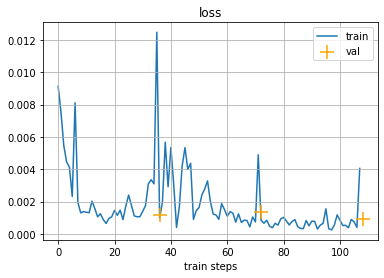

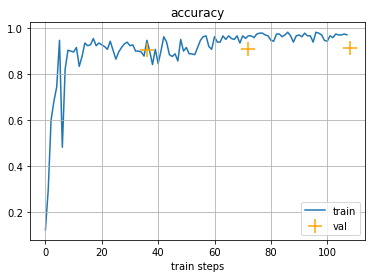

In [34]:
plot_history(best_hist[2]['train_loss_log'], best_hist[2]['val_loss_log'], "loss")
plot_history(best_hist[2]['train_acc_log'], best_hist[2]['val_acc_log'], "accuracy")

# Метрики

In [35]:
def predict(model, val_dataloder, criterion, device="cuda:0"):  
    model.eval()
    pred_l, true_lab = torch.empty(0), torch.empty(0)
    val_epoch_loss = torch.empty(0)

    with torch.no_grad():
        for imgs, labels_ in tqdm(val_dataloder):
            imgs, labels = imgs.to(device), labels_.to(device)
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            pred_l = torch.cat((pred_l.cpu(), y_pred.cpu()))
            true_lab = torch.cat((true_lab.cpu(), labels.cpu()))
            val_epoch_loss = torch.cat((val_epoch_loss.cpu(), loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
        predicted_classes = torch.argmax(pred_l, dim=-1).cpu()

        # return tensor - loss, tensor - predict, tensor - true y
    return torch.mean(val_epoch_loss), predicted_classes, true_lab

In [37]:
# Загрузим лучшую модель
best_model = torch.load(f'{path_unzip}/2/model_2.pt')
best_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [38]:
all_losses, predicted_labels, true_labels = predict(best_model, val_dataloader, criterion=cr, device=dev)
accuracy = accuracy_score(predicted_labels, true_labels)

  0%|          | 0/16 [00:00<?, ?it/s]

In [47]:
precision = precision_score(predicted_labels, true_labels, average=None)

In [51]:
print('Accuracy score for all classes:', accuracy)
print('Presicion score for each class:', precision)

Accuracy score for all classes: 0.9516416390939171
Presicion score for each class: [0.97310513 0.96813725 0.85645933 0.90178571 0.96758105 0.92383292
 0.98004988 0.98341232 0.98601399 0.95365854]


In [76]:
true_labels.unique()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Выводы

### Получена accuracy - **0.951**

### Presicion score for each class:

**0 - 0.97310513** - ши-тцу

**1 - 0.96813725** - родезийский риджбек

**2 - 0.85645933** - бигль

**3 - 0.90178571** - английский фоксхаунд

**4 - 0.96758105** - бордер-терьер

**5 - 0.92383292** - австралийский терьер

**6 - 0.98004988** - золотистый ретривер

**7 - 0.98341232** - староанглийская овчарка

**8 - 0.98601399** - самоед

**9 - 0.95365854** - динго

# Напишем функцию для прогнозов

In [115]:
# Зададим словарь классов
dog_breeds = {0 : 'ши-тцу', 
              1 : 'родезийский риджбек', 
              2 : 'бигль', 
              3 : 'английский фоксхаунд',
              4 : 'бордер-терьер',
              5 : 'австралийский терьер', 
              6 : 'золотистый ретривер',
              7 : 'староанглийская овчарка', 
              8 : 'самоед',
              9 : 'динго'}

In [116]:
data_dir =  f'{path_work}/train'

test_transforms = T.Compose([T.Resize(shape_resize),
                                     T.ToTensor(),])

In [117]:
def predict_image(image):
    '''INPUT
            -> image: PIL image
        OUTPUT
            -> predict idx_label, predict label
    '''
    
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inpt = Variable(image_tensor)
    inpt = inpt.to(dev)
    output = best_model(inpt)
    _, predicted = torch.max(output, 1)
    label = dog_breeds[predicted.item()]
    return predicted.item(), label

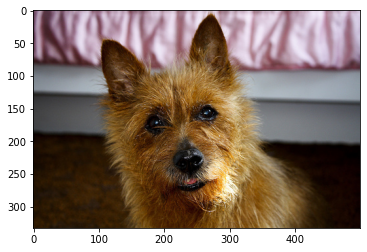

In [120]:
with Image.open("F:/Проекты/SBER CV/imagewoof2/train/n02096294/ILSVRC2012_val_00004605.JPEG") as im:
    plt.imshow(im)

In [121]:
predict_image(im)

(5, 'австралийский терьер')